In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import os
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

from torch.cuda.amp import autocast, GradScaler

C:\Users\matsvei\AppData\Local\Temp\ipykernel_8720\2013187680.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
dataset_path = 'D:/matvei/datasets/animal-10'
dataset_train = tv.datasets.ImageFolder(
    root=dataset_path,
    transform=transforms
)

In [3]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    dataset_train, shuffle=True,
    batch_size=batch_size, num_workers=1, drop_last=True
)

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
model = tv.models.vgg19(weights=tv.models.vgg.VGG19_Weights)

In [8]:
count_parameters(model)

143667240

In [9]:
model_resnet = tv.models.resnet50(weights=tv.models.resnet.ResNet50_Weights)

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
count_parameters(model_resnet)

25557032

In [16]:
classifier = nn.Sequential(
    nn.Linear(25088, 100),
    nn.LeakyReLU(0.2),
    nn.Linear(100, 10)
)

model.classifier = classifier

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, 
    gamma=0.6
)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [21]:
use_amp = True
scaler = torch.amp.GradScaler("cuda")

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [22]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach(), dim=1).numpy().argmax(axis=1) == label.numpy().argmax(axis=1)
    return answer.mean()

In [27]:
epochs = 3
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    pbar = tqdm(train_loader)
    for sample in pbar:
        img, label = sample
        label = F.one_hot(label, num_classes=10).float()
        img = img.to(device)
        label = label.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            pred = model(img)
            loss = loss_fn(pred, label)
        
        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        scaler.step(optimizer)
        scaler.update()
        
        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current
        
        pbar.set_description(f'loss: {loss_item:.4f}\taccuracy: {acc_current:3f}')
        
    scheduler.step()
    loss_epochs_list.append(loss_val / len(train_loader))
    acc_epochs_list.append(acc_val / len(train_loader))
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])
        
        

  0%|          | 0/1636 [00:00<?, ?it/s]

0.22113766185574982
0.9352078239608802


  0%|          | 0/1636 [00:00<?, ?it/s]

0.04271586275771078
0.9871256112469438


  0%|          | 0/1636 [00:00<?, ?it/s]

0.012250627293126216
0.9965617359413202


In [118]:
img = sample[0][8:9]

In [119]:
with torch.no_grad():
    ans = model(img.to(device))
    
F.softmax(ans.cpu(), dim=1)

tensor([[1.1919e-13, 2.0923e-13, 3.4530e-19, 3.3327e-09, 1.0000e+00, 8.8835e-12,
         9.3520e-15, 2.2304e-12, 1.5992e-14, 4.6518e-10]])

In [120]:
img_np = img[0].numpy()
img_np = img_np.transpose((1, 2, 0))

In [121]:
def normed(img, vmin=0, vmax=1):
    return (img - img.min()) * (vmax - vmin) / (img.max() - img.min()) + vmin

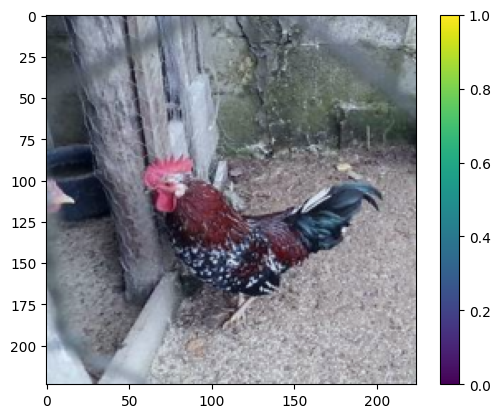

In [122]:
plt.imshow(normed(img_np))
plt.colorbar()

In [123]:
with torch.no_grad():
    torch.cuda.empty_cache()